In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from dalex import explainer
from sklearn.ensemble import RandomForestClassifier 
import numpy as np
from sklearn.linear_model import Ridge

In [37]:
def train_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print('Training R^2:', r2_score(y_train, model.predict(X_train)))
    print('Test R^2:', r2_score(y_test, model.predict(X_test)))

    plt.plot([0, 100000], [0, 100000], lw=2, color='orange')
    plt.scatter(y_train, y_pred_train)
    plt.xlabel("y_train")
    plt.ylabel("y_train_pred")
    plt.show()
    plt.plot([0, 100000], [0, 100000], lw=2, color='orange')
    plt.scatter(y_test, y_pred_test)
    plt.xlabel("y_train")
    plt.ylabel("y_train_pred")
    plt.show()
    

## Analiza danych: Medical Expenditure Panel Survey<br>
Cel: predykcja wydatków związanych z leczeniem

In [38]:
from aix360.datasets import MEPSDataset

In [13]:
data = MEPSDataset().data()
data.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)

#### Wartości zmiennej objaśnianej

W danych zbiorze występują wartości odstające. Zostały one usunięte na dwa sposoby: <br>
1) 'Naiwny' - ustalenie granicy, powyżej której obserwacje nie będą brane pod uwagę <br>
2) Za pomocą metody IsolationForest

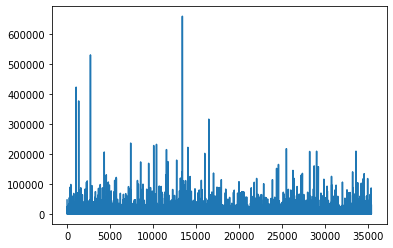

In [34]:
plt.plot(data.HEALTHEXP)

#### Ustalona wartość graniczna
Wytrenowano poniżej model GradientBoosting Regressor. 
Jedyną modyfikacją danych było manualne ustawienie maksymalnej wartości *HEALTHEXP*, wartość ta została wybrana wyłącznie po obejrzeniu wartości zmiennej. 


In [39]:
data1 = data[data['HEALTHEXP']<125000]

Training R^2: 0.4934790081417796
Test R^2: 0.2349768011698099


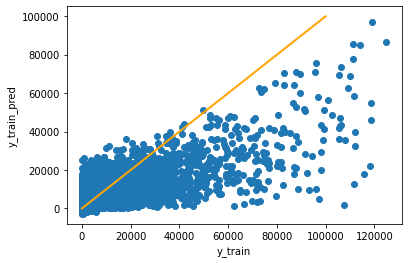

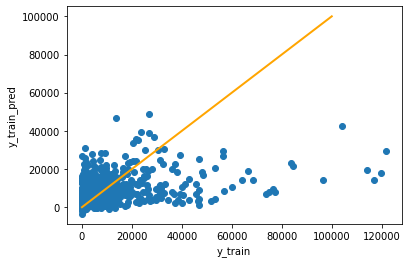

In [40]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1.drop({"HEALTHEXP"},1), data1['HEALTHEXP'], test_size=0.1, random_state=22)
raw_model = GradientBoostingRegressor(n_estimators=500, random_state=0)
train_predict(raw_model, X_train1, X_test1, y_train1, y_test1)

###  IsolationForest
Poniżej został wytrenowany model GradientBoostingRegressor po usunięciu wartości odstających metodą IsolationForest.

In [41]:
data2 = data
clf = IsolationForest(random_state=0).fit(data2)
outliers = clf.predict(data2)
data2['outliers']=outliers
data2 = data2[data2['outliers']==1].drop("outliers",1)

Training R^2: 0.5487325764436359
Test R^2: 0.07198363129961605


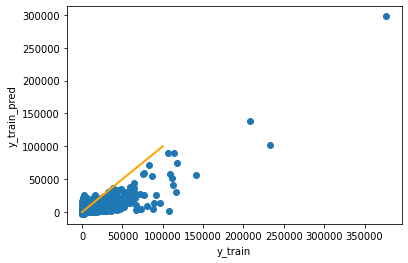

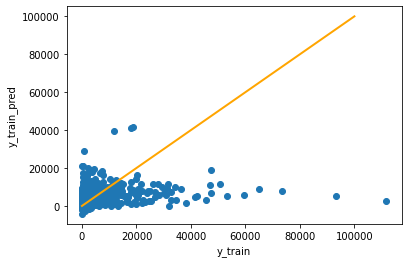

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data2.drop({"HEALTHEXP"},1), data2['HEALTHEXP'], test_size=0.1, random_state=22)
is_model = GradientBoostingRegressor(n_estimators=500, random_state=0)
train_predict(raw_model, X_train, X_test, y_train, y_test)

Nieco lepiej sprawdziła się metoda, która ograniczała wartości zmiennej objaśnianej. Zatem pierwszy model będzie dalej rozważany

### 3)  EXPLAIN

Wpływ zmiennych na pierwszą obserwację ze zbioru testowego na podstawie pierwszego modelu (z ograniczoną wartością *HEALTHEXP*).

In [64]:
exp = explainer.Explainer(model = raw_model, data = X_train1, y =y_train1, model_type='regression')
bd = exp.predict_parts(X_train1.iloc[0], type='break_down')
bd.plot(max_vars=46)

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 16483 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 16483 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x7fa7dc5fbb70> will be used
  -> predicted values  : min = -5308.150654318225, mean = 3859.059500834815, max = 90236.8683173888
  -> residual function : difference between y and yhat
  -> residuals         : min = -76301.6414738927, mean = 938.0436357301312, max = 123586.2993601908
  -> model_info        : package sklearn

A new explainer has been created!


## 4)

Wśród pierwszych pięciu obserwacji ze zbioru testowego występują 3 różne najistotniejsze zmienne:


In [43]:
bd = [exp.predict_parts(X_test.iloc[idx], type='break_down') for idx in range(5)]

In [44]:
for idx, df in enumerate(bd):
    print(idx+1, " observation from X_test1")
    result = df.result[:-1]
    result['contribution_abs'] = np.abs(result.contribution)
    result = result.sort_values(by=['contribution_abs'])
    print("Most important variable: ", result.iloc[-1].variable_name, "\n")

1  observation from X_test1
Most important variable:  K6SUM42 

2  observation from X_test1
Most important variable:  PCS42 

3  observation from X_test1
Most important variable:  intercept 

4  observation from X_test1
Most important variable:  PCS42 

5  observation from X_test1
Most important variable:  PCS42 



/home/kasia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 5)

Zmienna *INCOME_M* na pierwszą zmienną ze zbioru testowego ma wpływ negatywny, natomiast na drugą pozytywny.

In [21]:
bd[0].result.iloc[4]

variable_name                      INCOME_M
variable_value                      3.7e+04
variable                 INCOME_M = 3.7e+04
cumulative                          14891.7
contribution                       -144.167
sign                                     -1
position                                 40
label             GradientBoostingRegressor
Name: 4, dtype: object

Wydatki związane z leczeniem na pierwsza obserwację

In [131]:
y_test.iloc[0]

1026

In [25]:
bd[1].result.iloc[1]

variable_name                      INCOME_M
variable_value                      9.1e+04
variable                 INCOME_M = 9.1e+04
cumulative                          8126.11
contribution                        4267.05
sign                                      1
position                                 43
label             GradientBoostingRegressor
Name: 1, dtype: object

Wydatki związane z leczeniem na  drugą obserwację

In [128]:
y_test.iloc[1]

750

### 6)

Model Regresji grzbietowej z obserwacjami, u których zmienna objaśniana ma wartość mniejszą niż 125000

In [61]:
clf = Ridge(alpha=1.0)
clf.fit(X_train1, y_train1)    
print('Training R^2:', r2_score(y_train1, clf.predict(X_train1)))
print('Test R^2:', r2_score(y_test1, clf.predict(X_test1)))

Training R^2: 0.2123140901702143
Test R^2: 0.1770886062936905


In [80]:
exp2 = explainer.Explainer(model = clf, data = X_train1, y =y_train1, model_type='regression')
bd2 = exp2.predict_parts(X_train1.iloc[0], type='break_down')

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 16483 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 16483 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x7fa7d81aaa60> will be used
  -> predicted values  : min = -5461.599235071648, mean = 4797.103136564951, max = 28201.107443716577
  -> residual function : difference between y and yhat
  -> residuals         : min = -24566.76780829739, mean = -3.895989923119755e-12, max = 108738.32257469589
  -> model_info        : package sklearn

A new explainer has been created!


In [114]:
var_contr = obs2.result[['variable_name','contribution']].merge(obs1.result[['variable_name','contribution']], right_on='variable_name', left_on='variable_name')[:-1]

Poniższy wykres przedstawia wkład każdej ze zmiennych na pierwszą obserwację ze zbioru testowego. 
Na wykresie można zauważyć, że największą różnicę między modelem GBR a regresją grzbietową na daną obserwację mają zmienne o największym i najmniejszym wkładzie (najmniej pokrywają się ogony wykresu).

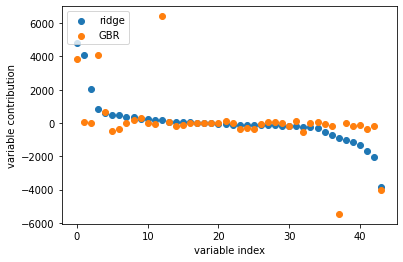

In [116]:
plt.scatter(np.arange(44), var_contr['contribution_x'],  label='ridge')
plt.scatter(np.arange(44), var_contr['contribution_y'],  label='GBR')
plt.xlabel("variable index")
plt.ylabel("variable contribution")
plt.legend(loc='upper left')
plt.show()

Występują także zmienne (np. przedstawiona wyżej INCOME_M) o wysokim pozytywnym wpływie na jedną zmienną i negatywnym na drugim. Na podstawie powyższego wykresu można zobaczyć skalę wpływu.